In [1]:
import numpy as np
import cv2
from imageio import imread
import matplotlib.pyplot as plt

In [2]:
dirname = 'stopsign/'
img_ref = imread(dirname + 'stop-reference.jpg')
img1 = imread(dirname + 'stop1.jpg')

In [5]:
def extract_correspondences(im1, im2, coeff=0.5):
    """
    im1: image to match
    im2: reference image
    return two lists of good-match keypoints
    """
    sift = cv2.xfeatures2d.SIFT_create()
    keypts1, desc1 = sift.detectAndCompute(im1, None)
    keypts2, desc2 = sift.detectAndCompute(im2, None)
    matches = cv2.BFMatcher().knnMatch(desc1, desc2, k=2)
    
    # find good matches above threshold
    good_keypts1 = []
    good_keypts2 = []
    for m1, m2 in matches:
        if m1.distance > coeff * m2.distance:
            continue
        good1 = keypts1[m1.queryIdx]
        good2 = keypts2[m1.trainIdx]
        good_keypts1.append(good1)
        good_keypts2.append(good2)
        
    return good_keypts1, good_keypts2

In [15]:
def get_vertices(im_ref):
    height, width = im_ref.shape[:2]
    points = np.stack([
        (0, 0), (width, 0), (width, height), (0, height)
    ]).astype(np.float32)
    return points

def reshape_vertices_for_cv2(points):
    vertices  = points.reshape((-1,1,2)).astype(np.int32)
    return vertices

def draw_bounding_box(im, vertices):
    ret = cv2.polylines(im.copy(), [vertices], isClosed=True, 
                   color=(0, 255, 255), thickness=5)
    return ret

In [16]:
def convert_vertices_using_keypoint_pairs(points, keypt, keypt_ref):
    """
    helper for visualization, probabaly not used in final
    vertices: from the reference image
    keypt: a single keypoint
    """
    # scale
    scale = keypt.size / keypt_ref.size
    points *= scale
    
    # translation
    points += keypt.pt
    points -= keypt_ref.pt
    
    # rotation
    angle = keypt.angle - keypt_ref.angle
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    points = points @ R.T
    
    return points

In [17]:
kpts, kpts_ref = extract_correspondences(img1, img_ref)

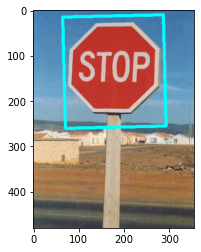

In [18]:
idx = 20
points_ref = get_vertices(img_ref)
points = convert_vertices_using_keypoint_pairs(
    points_ref, kpts[idx], kpts_ref[idx])
vertices = reshape_vertices_for_cv2(points)
im = draw_bounding_box(img1, vertices)
plt.imshow(im)

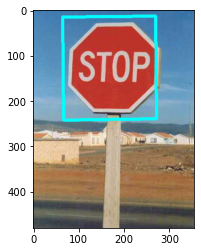

In [19]:
idx = 40
points_ref = get_vertices(img_ref)
points = convert_vertices_using_keypoint_pairs(
    points_ref, kpts[idx], kpts_ref[idx])
vertices = reshape_vertices_for_cv2(points)
im = draw_bounding_box(img1, vertices)
plt.imshow(im)

# Hough Transform

Maybe let's just use 2 quantization levels for each param in the votes. We have 4 params per vote, i.e., 16 candidate boxes.

In [ ]:
# now have keypoints vote on best bounding box